In [1]:
# Data Analysis
import numpy as np
import pandas as pd

# Data Visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix



# Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
def reduce_mem_usage(df):
    """ 
    Iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe is {start_mem:.2f} MB")
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object and str(col_type) != 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type).startswith('int'):
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                    
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                    
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                    
                else:
                    df[col] = df[col].astype(np.int64)
                    
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                    
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                    
                else:
                    df[col] = df[col].astype(np.float64)
                    
    end_mem = df.memory_usage().sum() / 1024**2
    print(f"Memory usage after optimization is: {end_mem:.2f} MB")
    print(f"Decreased by {(100 * (start_mem - end_mem) / start_mem):.1f}%")
    
    return df


Loading and cleaning data

In [3]:
# Loading train_transaction data
train_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
train_transaction = reduce_mem_usage(train_transaction)
print(train_transaction.shape)
train_transaction.head()

Memory usage of dataframe is 1775.15 MB
Memory usage after optimization is: 542.35 MB
Decreased by 69.4%
(590540, 394)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Loading train_identity data
train_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
train_identity = reduce_mem_usage(train_identity)
print(train_identity.shape)
train_identity.head()

Memory usage of dataframe is 45.12 MB
Memory usage after optimization is: 25.86 MB
Decreased by 42.7%
(144233, 41)


,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [5]:
# Merging transaction and identity train data
train_df = pd.merge(train_transaction, train_identity, how='left')
print(train_df.shape)
len_train_df = len(train_df)
del train_transaction, train_identity
train_df.head()

(590540, 434)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [6]:
# Loading test_transaction data
test_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv')
print(test_transaction.shape)
test_transaction = reduce_mem_usage(test_transaction)

# Loading test_identity data
test_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_identity.csv')
test_identity = reduce_mem_usage(test_identity)
print(test_identity.shape)


(506691, 393)
Memory usage of dataframe is 1519.24 MB
Memory usage after optimization is: 472.59 MB
Decreased by 68.9%
Memory usage of dataframe is 44.39 MB
Memory usage after optimization is: 25.44 MB
Decreased by 42.7%
(141907, 41)


In [7]:
# Merging transaction and identity test data
test_df = pd.merge(test_transaction, test_identity, how='left')
print(test_df.shape)
test_df.columns = train_df.drop('isFraud', axis=1).columns
del test_transaction, test_identity
test_df.head()

(506691, 433)


,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.953125,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.000000,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.000000,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,285.000000,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.937500,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Duplicates check in train data
train_df.duplicated().sum()

0

Preprocessing

In [9]:
combined_df = pd.concat([train_df.drop(columns=['isFraud', 'TransactionID']), test_df.drop(columns='TransactionID')])
print(f"combined_df shape: {combined_df.shape}")

# Dependant variable
y = train_df.isFraud
print(y.shape)

# Dropping columns with more than 20% missing values
miss_val = combined_df.isnull().sum() / len(combined_df)
print(miss_val.shape)
combined_pruned_df = combined_df.drop(columns=miss_val[miss_val > 0.2].index)

print(combined_pruned_df.shape)

combined_df shape: (1097231, 432)
(590540,)
(432,)
(1097231, 180)


In [10]:
# Filtering numerical data
num_pruned_df = combined_pruned_df.select_dtypes(include=np.number)
print(num_pruned_df.shape)

# Filtering categorical data
cat_pruned_df = combined_pruned_df.select_dtypes(exclude=np.number)
print(cat_pruned_df.shape)

del combined_pruned_df

# Filling missing values for numerical columns
# Numerical columns - fill with median
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
num_df = pd.DataFrame(imp_median.fit_transform(num_pruned_df), columns=num_pruned_df.columns)
del num_pruned_df
print(num_df.shape)

# Filling missing values for categorical columns
# Categorical columns - fill with mode
imp_max = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
cat_df = pd.DataFrame(imp_max.fit_transform(cat_pruned_df), columns=cat_pruned_df.columns)
del cat_pruned_df
print(cat_df.shape)

# Concatinating numerical and categorical columns
combined_df = pd.concat([num_df, cat_df], axis=1)
del num_df, cat_df

# Checking for missing values
print(f'Total missing values: {combined_df.isnull().sum().sum()}')
print(combined_df.shape)

(1097231, 176)
(1097231, 4)
(1097231, 176)
(1097231, 4)
Total missing values: 0
(1097231, 180)


In [11]:
# One-hot encoding
combined_df_encoded = pd.get_dummies(combined_df, drop_first=True)
print(combined_df_encoded.shape)
del combined_df
combined_df_encoded.head()

(1097231, 245)


,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,...,P_emaildomain_web.de,P_emaildomain_windstream.net,P_emaildomain_yahoo.co.jp,P_emaildomain_yahoo.co.uk,P_emaildomain_yahoo.com,P_emaildomain_yahoo.com.mx,P_emaildomain_yahoo.de,P_emaildomain_yahoo.es,P_emaildomain_yahoo.fr,P_emaildomain_ymail.com
0,86400.0,68.5,13926.0,361.0,150.0,142.0,315.0,87.0,1.0,1.0,...,False,False,False,False,False,False,False,False,False,False
1,86401.0,29.0,2755.0,404.0,150.0,102.0,325.0,87.0,1.0,1.0,...,False,False,False,False,False,False,False,False,False,False
2,86469.0,59.0,4663.0,490.0,150.0,166.0,330.0,87.0,1.0,1.0,...,False,False,False,False,False,False,False,False,False,False
3,86499.0,50.0,18132.0,567.0,150.0,117.0,476.0,87.0,2.0,5.0,...,False,False,False,False,True,False,False,False,False,False
4,86506.0,50.0,4497.0,514.0,150.0,102.0,420.0,87.0,1.0,1.0,...,False,False,False,False,False,False,False,False,False,False


In [12]:
# Separating train and test data
X = combined_df_encoded.iloc[:len_train_df]
print(X.shape)
test = combined_df_encoded.iloc[len_train_df:]
print(test.shape)
del combined_df_encoded

(590540, 245)
(506691, 245)


 understand the distribution of timestamp over the dataset.

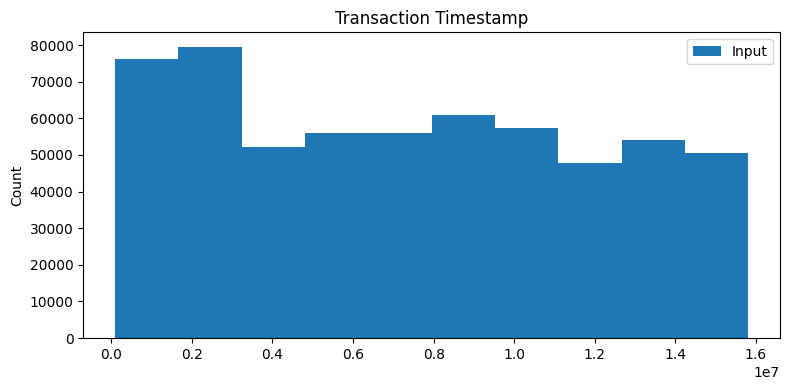

In [13]:
plt.figure(figsize=(8,4))
plt.hist(X['TransactionDT'], label='Input')
plt.ylabel('Count')
plt.title('Transaction Timestamp')
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
len(X.TransactionDT.unique()), len(X.TransactionDT)


(573349, 590540)

The plot above indicates that the number of transactions is higher at the initial timestamps. Therefore, it would be best to split the training and validation sets based on time.

In [15]:
train = pd.concat([X, y], axis=1)
train.sort_values('TransactionDT', inplace=True)
X = train.drop(columns=['isFraud'])
# or X = train.drop(['isFraud'], axis=1)
y = train['isFraud']


In [16]:
# Lists to store performance metrics
auc_scores_rf = []
auc_scores_xgb = []
auc_scores_lr = []


Implement Stratified K-Fold Cross-Validation

In [17]:
# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store performance metrics
auc_scores_rf = []
auc_scores_xgb = []
auc_scores_lr = []

for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
    print(f"\nFold {fold + 1}")
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    # Apply SMOTE to the training fold
    smote = SMOTE(sampling_strategy=0.5, random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_fold, y_train_fold)



Fold 1

Fold 2

Fold 3

Fold 4

Fold 5


Hyperparameter Tuning for Random Forest

In [18]:
# Define Parameter Grid
param_grid = {
        "n_estimators": [100, 200],
        "max_depth": [None, 10],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2],
        "max_features": ["auto", "sqrt"],
        "bootstrap": [True, False],
    }

# Initialize Random Forest Classifier
rfc = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
        estimator=rfc,
        param_grid=param_grid,
        cv=3,
        n_jobs=-1,
        scoring="roc_auc",
        verbose=1,
    )    

 # Fit GridSearchCV
grid_search.fit(X_train_smote, y_train_smote)

# Retrieve Best Parameters
print(f"Best Parameters for fold {fold + 1}: {grid_search.best_params_}")
best_rfc = grid_search.best_estimator_

# Evaluate on Validation Set
y_probs_rf = best_rfc.predict_proba(X_val_fold)[:, 1]
auc_rf = roc_auc_score(y_val_fold, y_probs_rf)
auc_scores_rf.append(auc_rf)
print(f"AUC Score for Random Forest in Fold {fold + 1}: {auc_rf:.4f}")

Fitting 3 folds for each of 64 candidates, totalling 192 fits


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Best Parameters for fold 5: {'bootstrap': False, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
AUC Score for Random Forest in Fold 5: 0.9295


XGBoost

In [19]:
    xgb_model = XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        use_label_encoder=False,
        eval_metric="auc",
    )
    xgb_model.fit(X_train_smote, y_train_smote)
    y_probs_xgb = xgb_model.predict_proba(X_val_fold)[:, 1]
    auc_xgb = roc_auc_score(y_val_fold, y_probs_xgb)
    auc_scores_xgb.append(auc_xgb)
    print(f"AUC Score for XGBoost in Fold {fold + 1}: {auc_xgb:.4f}")

AUC Score for XGBoost in Fold 5: 0.8976


In [20]:
    # Logistic Regression
    lr_model = LogisticRegression(
        max_iter=1000, class_weight="balanced", solver="liblinear"
    )
    lr_model.fit(X_train_smote, y_train_smote)
    y_probs_lr = lr_model.predict_proba(X_val_fold)[:, 1]
    auc_lr = roc_auc_score(y_val_fold, y_probs_lr)
    auc_scores_lr.append(auc_lr)
    print(f"AUC Score for Logistic Regression in Fold {fold + 1}: {auc_lr:.4f}")


AUC Score for Logistic Regression in Fold 5: 0.7348


Evaluating overall Performance

In [21]:
# Evaluating overall Performance
avg_auc_rf = np.mean(auc_scores_rf)
avg_auc_xgb = np.mean(auc_scores_xgb)
avg_auc_lr = np.mean(auc_scores_lr)

print(f"\nAverage AUC Score for Random Forest: {avg_auc_rf:.4f}")
print(f"Average AUC Score for XGBoost: {avg_auc_xgb:.4f}")
print(f"Average AUC Score for Logistic Regression: {avg_auc_lr:.4f}")



Average AUC Score for Random Forest: 0.9295
Average AUC Score for XGBoost: 0.8976
Average AUC Score for Logistic Regression: 0.7348


Final Model Evaluation

In [22]:
# Determine the best model based on average AUC
model_performance = {
    'Random Forest': avg_auc_rf,
    'XGBoost': avg_auc_xgb,
    'Logistic Regression': avg_auc_lr
}

best_model_name = max(model_performance, key=model_performance.get)
best_model_auc = model_performance[best_model_name]

print(f"\nBest Model: {best_model_name} with Average AUC: {best_model_auc:.4f}")


Best Model: Random Forest with Average AUC: 0.9295



Optimal Threshold: 0.3020


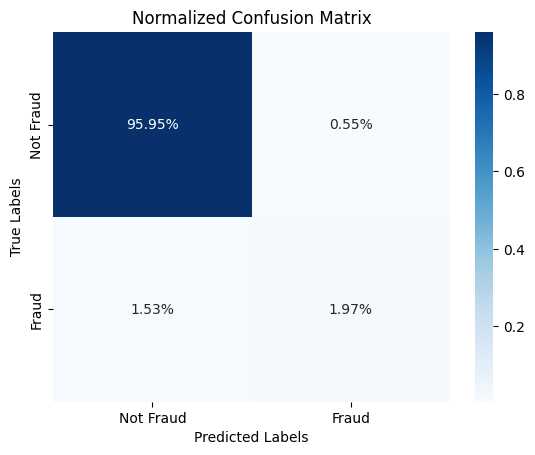


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99    113975
           1       0.78      0.56      0.65      4133

    accuracy                           0.98    118108
   macro avg       0.88      0.78      0.82    118108
weighted avg       0.98      0.98      0.98    118108



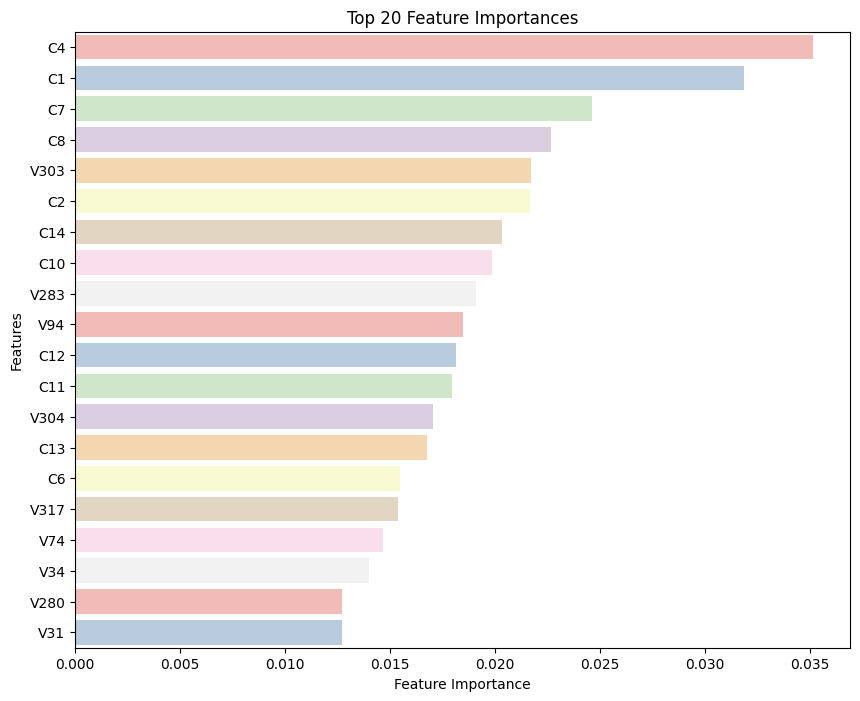

In [23]:
# Selecting the best model based on AUC scores
if best_model_name == 'Random Forest':
    best_model = best_rfc
elif best_model_name == 'XGBoost':
    best_model = xgb_model
elif best_model_name == 'Logistic Regression':
    best_model = lr_model
else:
    raise ValueError("Unexpected model name.")

# Proceed with evaluation using the best model
X_val_final = X_val_fold  # From the last fold
y_val_final = y_val_fold

# Calculate precision and recall for different thresholds
y_probs_final = best_model.predict_proba(X_val_final)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val_final, y_probs_final)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)

# Find the threshold that gives the maximum F1 score
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"\nOptimal Threshold: {optimal_threshold:.4f}")

# Use the optimal threshold for predictions
y_pred_labels = (y_probs_final >= optimal_threshold).astype(int)

# Confusion Matrix
conf_matrix = confusion_matrix(y_val_final, y_pred_labels)
sns.heatmap(
    conf_matrix / np.sum(conf_matrix),
    annot=True,
    fmt=".2%",
    cmap="Blues",
    xticklabels=["Not Fraud", "Fraud"],
    yticklabels=["Not Fraud", "Fraud"],
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Normalized Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_val_final, y_pred_labels))

# Feature Importances (if applicable)
if hasattr(best_model, 'feature_importances_'):
    feature_importances = pd.Series(best_model.feature_importances_, index=X.columns)
    top_features = feature_importances.nlargest(20)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x=top_features.values, y=top_features.index, palette="Pastel1")
    plt.xlabel("Feature Importance")
    plt.ylabel("Features")
    plt.title("Top 20 Feature Importances")
    plt.show()
elif best_model_name == 'Logistic Regression':
    # For Logistic Regression, use coefficients
    feature_importances = pd.Series(best_model.coef_[0], index=X.columns).abs()
    top_features = feature_importances.nlargest(20)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x=top_features.values, y=top_features.index, palette="Pastel1")
    plt.xlabel("Feature Coefficient Magnitude")
    plt.ylabel("Features")
    plt.title("Top 20 Feature Coefficients")
    plt.show()
